In [1]:
# importing the libraries
import numpy as np

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import pickle
def load_data(in_dir):
    f = open(in_dir,'rb')
    train_data,train_label,valid_data,valid_label = pickle.load(f)
    return train_data,train_label,valid_data,valid_label

data_path = 'adress_pssat.pkl'
checkpoint = 'checkpoint/'

train_data,train_label,valid_data,valid_label = load_data(data_path)

In [2]:
# converting training images into torch format
train_x = train_data
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_label
train_y = train_y.reshape(train_y.shape[0]).astype(float);
train_y = torch.from_numpy(train_y)

# train_y =torch.randn(train_y.shape[0],2)

# shape of training data
# train_x.shape, train_y.shape
from torch.utils.data import TensorDataset, DataLoader

CTX = torch.device('cuda')

train_dataset = TensorDataset(train_x.to(device = CTX, dtype=torch.float),train_y.to(device = CTX, dtype=torch.float)) # create your datset

 # create your dataloader
# converting training images into torch format
val_x = valid_data
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = valid_label
val_y = val_y.reshape(val_y.shape[0]).astype(float);
val_y = torch.from_numpy(val_y)
# shape of training data
# val_y = np.random((val_y.shape[0],2)).astype(float)
# val_y =torch.randn(val_y.shape[0],2)
val_dataset = TensorDataset(val_x,val_y) # create your datset

In [3]:
train_x.shape,val_y.shape

(torch.Size([2413, 3, 300, 40]), torch.Size([128]))

In [4]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 16

train_dl = DataLoader(train_dataset,batch_size, shuffle = True, num_workers = 0)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers = 0)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
#         print(labels.shape)
        out , features = self(images.to(CTX))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out , features= self(images.to(device = CTX, dtype=torch.float))   
#         print(out.shape)# Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda())   # Calculate loss
        acc = accuracy(out, labels.to(torch.int64).cuda())           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.6f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [6]:
import math
import logging
import warnings
from functools import partial
from collections import OrderedDict
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F

from timm.models.layers.helpers import to_2tuple

In [7]:
def adapt_input_conv(in_chans, conv_weight):
    conv_type = conv_weight.dtype
    conv_weight = conv_weight.float()  # Some weights are in torch.half, ensure it's float for sum on CPU
    O, I, J, K = conv_weight.shape
    if in_chans == 1:
        if I > 3:
            assert conv_weight.shape[1] % 3 == 0
            # For models with space2depth stems
            conv_weight = conv_weight.reshape(O, I // 3, 3, J, K)
            conv_weight = conv_weight.sum(dim=2, keepdim=False)
        else:
            conv_weight = conv_weight.sum(dim=1, keepdim=True)
    elif in_chans != 3:
        if I != 3:
            raise NotImplementedError('Weight format not supported by conversion.')
        else:
            # NOTE this strategy should be better than random init, but there could be other combinations of
            # the original RGB input layer weights that'd work better for specific cases.
            repeat = int(math.ceil(in_chans / 3))
            conv_weight = conv_weight.repeat(1, repeat, 1, 1)[:, :in_chans, :, :]
            conv_weight *= (3 / float(in_chans))
    conv_weight = conv_weight.to(conv_type)
    return conv_weight

In [8]:
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """

    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [9]:
class PatchEmbed(nn.Module):
    """ 2D Image to Patch Embedding
    """

    def __init__(self, img_size=40, patch_size=8, stride=8, in_chans=3, embed_dim=256, norm_layer=None,
                 flatten=True):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        stride = to_2tuple(stride)
        self.img_size = img_size
        self.patch_size = patch_size
        self.stride = stride
        self.grid_size = (img_size[0] // stride[0], img_size[1] // stride[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        if not (H == self.img_size[0] and W == self.img_size[1]):
            warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")
        # to do maybe replace weights
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
        x = self.norm(x)
        if first_RUN: print("self.norm(x)", x.size())
        return x


In [10]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=4, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [11]:

class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=3., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [12]:
class PaSST(ImageClassificationBase):
    """
    Based on the implementation of Vision Transformer in timm library.
     Take a look at the get_model function, adapting the weights of pretrained imagenet models.
    """

    def __init__(self, u_patchout=2, s_patchout_t=4, s_patchout_f=2, img_size=(300, 40), patch_size=16, stride=16,
                 in_chans=3, num_classes=2, embed_dim=128, depth=12,
                 num_heads=4, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None, weight_init=''):
        """
        Args:
            u_patchout: Unstructured Patchout integer, number of items to be removed from the final sequence
            s_patchout_t: structured Patchout time integer, number of columns to be removed from the patches grid
            s_patchout_f: structured Patchout Frequency integer, number of rows to be removed from the patches grid
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
            weight_init: (str): weight init scheme
        """
        super().__init__()
        self.num_classes = num_classes
        self.u_patchout = u_patchout
        self.s_patchout_t = s_patchout_t
        self.s_patchout_f = s_patchout_f
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(
            img_size=img_size, patch_size=patch_size, stride=stride, in_chans=in_chans, embed_dim=embed_dim,
            flatten=False)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        # PaSST
        # refer to https://arxiv.org/abs/2110.05069 Section 2
        self.new_pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, embed_dim))  # for C and D tokens
        self.freq_new_pos_embed = nn.Parameter(torch.zeros(1, embed_dim, self.patch_embed.grid_size[0], 1))  # | f
        self.time_new_pos_embed = nn.Parameter(torch.zeros(1, embed_dim, 1, self.patch_embed.grid_size[1]))  # __ t
        ####
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop_rate,
                attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Sequential(nn.LayerNorm(self.num_features),
                                  nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity())
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        self.init_weights(weight_init)

    def init_weights(self, mode=''):
        assert mode in ('jax', 'jax_nlhb', 'nlhb', '')
        head_bias = -math.log(self.num_classes) if 'nlhb' in mode else 0.
        trunc_normal_(self.new_pos_embed, std=.02)
        trunc_normal_(self.freq_new_pos_embed, std=.02)
        trunc_normal_(self.time_new_pos_embed, std=.02)
        if self.dist_token is not None:
            trunc_normal_(self.dist_token, std=.02)
        if mode.startswith('jax'):
            # leave cls token as zeros to match jax impl
            raise RuntimeError("Not supported yet")
        else:
            trunc_normal_(self.cls_token, std=.02)
            self.apply(_init_vit_weights)

    def _init_weights(self, m):
        # this fn left here for compat with downstream users
        _init_vit_weights(m)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'new_pos_embed', 'freq_new_pos_embed', 'time_new_pos_embed', 'cls_token', 'dist_token'}

    def get_classifier(self):
        if self.dist_token is None:
            return self.head
        else:
            return self.head, self.head_dist

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        if self.num_tokens == 2:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        global first_RUN  # not jit friendly? use trace instead
        x = self.patch_embed(x)  # [b, e, f, t]
        B_dim, E_dim, F_dim, T_dim = x.shape  # slow
        if first_RUN: print(" patch_embed : ", x.shape)
        # Adding Time/Freq information
        if first_RUN: print(" self.time_new_pos_embed.shape", self.time_new_pos_embed.shape)
        time_new_pos_embed = self.time_new_pos_embed
        if x.shape[-1] < time_new_pos_embed.shape[-1]:
            if self.training:
                toffset = torch.randint(1 + time_new_pos_embed.shape[-1] - x.shape[-1], (1,)).item()
                if first_RUN: print(f" CUT with randomoffset={toffset} time_new_pos_embed.shape",
                                    time_new_pos_embed.shape)
                time_new_pos_embed = time_new_pos_embed[:, :, :, toffset:toffset + x.shape[-1]]
            else:
                time_new_pos_embed = time_new_pos_embed[:, :, :, :x.shape[-1]]
            if first_RUN: print(" CUT time_new_pos_embed.shape", time_new_pos_embed.shape)
        else:
            warnings.warn(
                f"the patches shape:{x.shape} are larger than the expected time encodings {time_new_pos_embed.shape}, x will be cut")
            x = x[:, :, :, :time_new_pos_embed.shape[-1]]
        x = x + time_new_pos_embed
        if first_RUN: print(" self.freq_new_pos_embed.shape", self.freq_new_pos_embed.shape)
        x = x + self.freq_new_pos_embed

        # Structured Patchout https://arxiv.org/abs/2110.05069 Section 2.2
        if self.training and self.s_patchout_t:
            if first_RUN: print(f"X Before time Patchout of {self.s_patchout_t} ", x.size())
            # ([1, 768, 1, 82])
            random_indices = torch.randperm(T_dim)[:T_dim - self.s_patchout_t].sort().values
            x = x[:, :, :, random_indices]
            if first_RUN: print("X after time Patchout", x.size())
        if self.training and self.s_patchout_f:
            if first_RUN: print(f"X Before Freq Patchout of {self.s_patchout_f} ", x.size())
            # [1, 768, 12, 1]
            random_indices = torch.randperm(F_dim)[:F_dim - self.s_patchout_f].sort().values
            x = x[:, :, random_indices, :]
            if first_RUN: print(" \n X after freq Patchout: ", x.size())
        ###
        # Flatten the sequence
        x = x.flatten(2).transpose(1, 2)
        # Unstructured Patchout
        if first_RUN: print("X flattened", x.size())
        if self.training and self.u_patchout:
            seq_len = x.shape[1]
            random_indices = torch.randperm(seq_len)[:seq_len - self.u_patchout].sort().values
            x = x[:, random_indices, :]
            if first_RUN: print("X After Unstructured Patchout", x.size())
        ####
        # Add the C/D tokens
        if first_RUN: print(" self.new_pos_embed.shape", self.new_pos_embed.shape)
        cls_tokens = self.cls_token.expand(B_dim, -1, -1) + self.new_pos_embed[:, :1, :]
        if first_RUN: print(" self.cls_tokens.shape", cls_tokens.shape)
        if self.dist_token is None:
            x = torch.cat((cls_tokens, x), dim=1)
        else:
            dist_token = self.dist_token.expand(B_dim, -1, -1) + self.new_pos_embed[:, 1:, :]
            if first_RUN: print(" self.dist_token.shape", dist_token.shape)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)

        if first_RUN: print(" final sequence x", x.shape)
        x = self.pos_drop(x)
        x = self.blocks(x)
        if first_RUN: print(f" after {len(self.blocks)} atten blocks x", x.shape)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        global first_RUN
        if first_RUN: print("x", x.size())

        x = self.forward_features(x)

        if self.head_dist is not None:
            features = (x[0] + x[1]) / 2
            if first_RUN: print("forward_features", features.size())
            x = self.head(features)
            if first_RUN: print("head", x.size())
            first_RUN = False
            return x, features
        else:
            features = x
            if first_RUN: print("forward_features", features.size())
            x = self.head(x)
        if first_RUN: print("head", x.size())
        first_RUN = False
        return x, features

In [13]:
from torch.nn.init import _calculate_fan_in_and_fan_out


def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

def _init_vit_weights(module: nn.Module, name: str = '', head_bias: float = 0., jax_impl: bool = False):
    """ ViT weight initialization
    * When called without n, head_bias, jax_impl args it will behave exactly the same
      as my original init for compatibility with prev hparam / downstream use cases (ie DeiT).
    * When called w/ valid n (module name) and jax_impl=True, will (hopefully) match JAX impl
    """
    if isinstance(module, nn.Linear):
        if name.startswith('head'):
            nn.init.zeros_(module.weight)
            nn.init.constant_(module.bias, head_bias)
        elif name.startswith('pre_logits'):
            lecun_normal_(module.weight)
            nn.init.zeros_(module.bias)
        else:
            if jax_impl:
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    if 'mlp' in name:
                        nn.init.normal_(module.bias, std=1e-6)
                    else:
                        nn.init.zeros_(module.bias)
            else:
                trunc_normal_(module.weight, std=.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    elif jax_impl and isinstance(module, nn.Conv2d):
        # NOTE conv was left to pytorch default in my original init
        lecun_normal_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, (nn.LayerNorm, nn.GroupNorm, nn.BatchNorm2d)):
        nn.init.zeros_(module.bias)
        nn.init.ones_(module.weight)


In [14]:
# hparams = {
#         "n_cnn_layers": 3,
#         "n_rnn_layers": 5,
#         "rnn_dim": 128,
#         "n_class": 2,
#         "n_feats": 64,
#         "stride": 2,
#         "dropout": 0.1,
#         "learning_rate": 0.07,
#         "batch_size": 32,
#         "epochs": 1000
#     }


CTX = torch.device('cuda')
# defining the model
# model = SpeechRecognitionModel(
#         hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
#         hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
#         ).to(CTX)

model = PaSST()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=128, out_features=384, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=512, out_features=128, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
 

In [15]:
first_RUN = True
from torchsummary import summary
summary(model, (3, 300, 40))

x torch.Size([2, 3, 300, 40])
self.norm(x) torch.Size([2, 128, 18, 2])
 patch_embed :  torch.Size([2, 128, 18, 2])
 self.time_new_pos_embed.shape torch.Size([1, 128, 1, 2])
 self.freq_new_pos_embed.shape torch.Size([1, 128, 18, 1])
X Before time Patchout of 4  torch.Size([2, 128, 18, 2])
X after time Patchout torch.Size([2, 128, 18, 0])
X Before Freq Patchout of 2  torch.Size([2, 128, 18, 0])
 
 X after freq Patchout:  torch.Size([2, 128, 16, 0])
X flattened torch.Size([2, 0, 128])
X After Unstructured Patchout torch.Size([2, 0, 128])
 self.new_pos_embed.shape torch.Size([1, 1, 128])
 self.cls_tokens.shape torch.Size([2, 1, 128])
 final sequence x torch.Size([2, 1, 128])


C:\Users\Asus\AppData\Local\Temp/ipykernel_10760/2287412027.py:140: UserWarning: the patches shape:torch.Size([2, 128, 18, 2]) are larger than the expected time encodings torch.Size([1, 128, 1, 2]), x will be cut
  warnings.warn(


 after 12 atten blocks x torch.Size([2, 1, 128])
forward_features torch.Size([2, 128])
head torch.Size([2, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 128, 18, 2]          98,432
          Identity-2           [-1, 128, 18, 2]               0
        PatchEmbed-3           [-1, 128, 18, 2]               0
           Dropout-4               [-1, 1, 128]               0
         LayerNorm-5               [-1, 1, 128]             256
            Linear-6               [-1, 1, 384]          49,536
           Dropout-7              [-1, 4, 1, 1]               0
            Linear-8               [-1, 1, 128]          16,512
           Dropout-9               [-1, 1, 128]               0
        Attention-10               [-1, 1, 128]               0
         Identity-11               [-1, 1, 128]               0
        LayerNorm-12               [-1, 1, 128]         

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [17]:
# CTX = torch.device('cuda')
# train_dl.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # train_dl.train_labels.to(CTX)
# # val_dl.train_data.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # val_dl.train_labels.to(CTX)
num_epochs = 24
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


C:\Users\Asus\AppData\Local\Temp/ipykernel_10760/2287412027.py:140: UserWarning: the patches shape:torch.Size([16, 128, 18, 2]) are larger than the expected time encodings torch.Size([1, 128, 1, 2]), x will be cut
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp/ipykernel_10760/2287412027.py:140: UserWarning: the patches shape:torch.Size([13, 128, 18, 2]) are larger than the expected time encodings torch.Size([1, 128, 1, 2]), x will be cut
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp/ipykernel_10760/2287412027.py:140: UserWarning: the patches shape:torch.Size([32, 128, 18, 2]) are larger than the expected time encodings torch.Size([1, 128, 1, 2]), x will be cut
  warnings.warn(


Epoch [0], train_loss: 0.708550, val_loss: 0.6845, val_acc: 0.5625
Epoch [1], train_loss: 0.687470, val_loss: 0.6897, val_acc: 0.5625
Epoch [2], train_loss: 0.687961, val_loss: 0.6882, val_acc: 0.5625
Epoch [3], train_loss: 0.686043, val_loss: 0.6850, val_acc: 0.5625
Epoch [4], train_loss: 0.686385, val_loss: 0.6857, val_acc: 0.5625
Epoch [5], train_loss: 0.686360, val_loss: 0.6854, val_acc: 0.5625
Epoch [6], train_loss: 0.684506, val_loss: 0.6813, val_acc: 0.5781
Epoch [7], train_loss: 0.684955, val_loss: 0.6836, val_acc: 0.5703
Epoch [8], train_loss: 0.685285, val_loss: 0.6813, val_acc: 0.5781
Epoch [9], train_loss: 0.684948, val_loss: 0.6866, val_acc: 0.5625
Epoch [10], train_loss: 0.685724, val_loss: 0.6871, val_acc: 0.5625
Epoch [11], train_loss: 0.685109, val_loss: 0.6855, val_acc: 0.5625
Epoch [12], train_loss: 0.684542, val_loss: 0.6857, val_acc: 0.5625
Epoch [13], train_loss: 0.684488, val_loss: 0.6859, val_acc: 0.5625
Epoch [14], train_loss: 0.684569, val_loss: 0.6816, val_ac

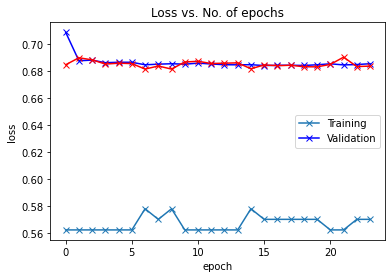

In [18]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [19]:
max([x['val_acc'] for x in history])

0.578125